# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [318]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [319]:
# using SQLite Table to read data.
con = sqlite3.connect('./AmazonFoodReviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [320]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [321]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [322]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [323]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [324]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [325]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [326]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [327]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [328]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [329]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [330]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [331]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [332]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [333]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:01<00:00, 1438.90it/s]


In [334]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [335]:
## Similartly you can do preprocessing for review summary also.

### Splitting data

In [336]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# Without appendending summary
X = preprocessed_reviews
Y = final['Score']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

# [4] Featurization

## [4.1] BAG OF WORDS

In [337]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)

bow_train = count_vect.transform(X_train)
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)

## [4.2] Bi-Grams and n-Grams.

In [338]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [339]:
#TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)

#train data
tf_idf_train = tf_idf_vect.transform(X_train)
#test data
tf_idf_test = tf_idf_vect.transform(X_test)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [340]:
# TRAIN DATA
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


avgw2v_train = []; 
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_train.append(sent_vec)
    
# TEST DATA
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
avgw2v_test = []; 
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_test.append(sent_vec)


100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [00:52<00:00, 554.30it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [341]:
############# TRAIN DATA
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

model = TfidfVectorizer()
model.fit(X_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() 
tfidfW2V_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfW2V_train.append(sent_vec)
    row += 1

################## TEST DATA
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
    
model = TfidfVectorizer()
model.fit(X_test)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() 
tfidfW2V_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfW2V_test.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 28966/28966 [06:31<00:00, 73.98it/s]


# Applying Logistic Regression

### Finding Hyperparameter Lambda L

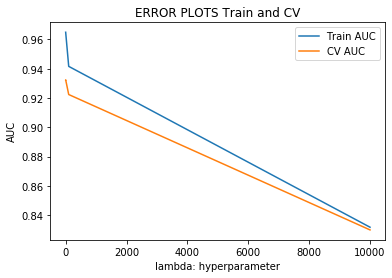

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.9495523660650846


In [342]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
L = [10**-4, 10**-2, 10**0, 10**2, 10**4]
for i in L:
    #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    clf = LogisticRegression(C=(1/i), solver='saga')
    clf.fit(bow_train, y_train)
    y_train_pred =  clf.predict_log_proba(bow_train)[:,1]
    y_cv_pred =  clf.predict_log_proba(bow_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(L, train_auc, label='Train AUC')
plt.plot(L, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS Train and CV")
plt.show()

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1')
model.fit(bow_train, y_train)

print(model.best_estimator_)
print(model.score(bow_test, y_test))


### Error Plot Function

In [343]:
def error_plot(train_data, test_data, penalty):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    from sklearn.metrics import roc_curve, auc

    c = 0.9496847671344315
    clf = LogisticRegression(C=c, solver='saga', penalty = penalty)
    clf.fit(train_data, y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(train_data)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(test_data)[:,1])
    print(thresholds)

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()

    print("="*100)

    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    print(confusion_matrix(y_train, clf.predict(train_data)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, clf.predict(test_data)))
    sns.heatmap(confusion_matrix(y_test, clf.predict(test_data)))
    return clf

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

[2.00000000e+00 1.00000000e+00 9.99997812e-01 ... 2.93786738e-05
 2.60058534e-05 6.80273598e-08]


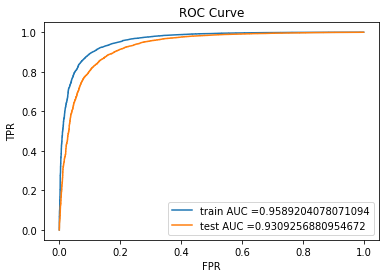

Train confusion matrix
[[ 4378  1970]
 [  687 32365]]
Test confusion matrix
[[ 2944  1737]
 [  703 23582]]
Sparsity on the weight vector
5961


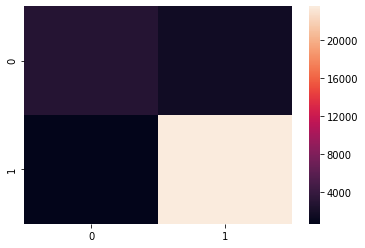

In [344]:
clf = error_plot(bow_train, bow_test, 'l1')
w_bow = clf.coef_
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

[2.00000000e+00 1.00000000e+00 9.99998681e-01 ... 3.63184964e-05
 2.66565786e-05 3.93222773e-08]


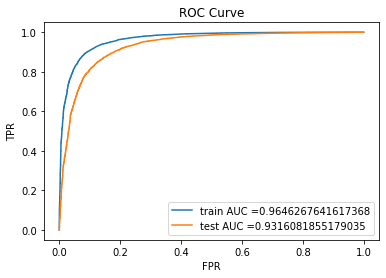

Train confusion matrix
[[ 4539  1809]
 [  638 32414]]
Test confusion matrix
[[ 2973  1708]
 [  723 23562]]
Sparsity on the weight vector
37468


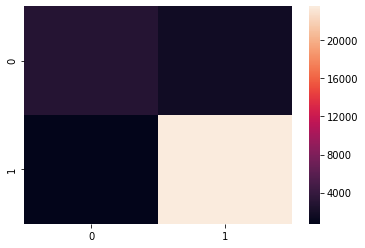

In [345]:
clf = error_plot(bow_train, bow_test, 'l2')
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [346]:
e = 0.00193123   #Randomly generated with uniform distribution
bow_train.data= bow_train.data+e

c = 0.9496847671344315
clf = LogisticRegression(C=c, solver='saga', penalty = 'l1')
clf.fit(bow_train, y_train)
w_bow_e = clf.coef_
w_bow = w_bow + 10**-6
w_bow_e = w_bow_e + 10**-6

[-0.00046332 -0.00031226 -0.00031064 ...  0.00089509  0.00153059
 -0.00122597]
[ 0.89607868  0.08852044 18.83426566 ... 31.48597958  8.39322084
 11.78918679]
1036889.126943178
99.0 th percentile 32.795593304411156
99.1 th percentile 37.835889420621044
99.2 th percentile 42.353414507635264
99.3 th percentile 48.20510572320629
99.4 th percentile 60.02592085853745
99.5 th percentile 75.54201521953686
99.6 th percentile 99.37573204575686
99.7 th percentile 117.08169061838049
99.8 th percentile 239.41448375329503
99.9 th percentile 754.3227062495228
100.0 th percentile 1036889.126943178


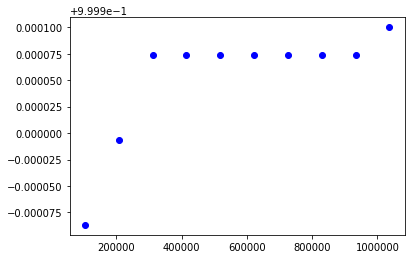

['acidity', 'allowed', 'aroma', 'asking', 'boylan', 'breathe', 'butcher', 'candida', 'canidae', 'cap', 'celebrity', 'chihuahuas', 'children', 'chip', 'considered', 'creates', 'crushing', 'crying', 'dispensers', 'dissatisfaction', 'doctor', 'doesnt', 'earned', 'embarrased', 'english', 'entirely', 'fingers', 'funky', 'grasshoppers', 'groom', 'haired', 'hutch', 'im', 'kidding', 'killing', 'krispies', 'lawyer', 'licks', 'listen', 'loops', 'manhattans', 'martini', 'materials', 'messier', 'oil', 'organisms', 'orleans', 'overjoyed', 'papillon', 'perservatives', 'pistachios', 'preserves', 'professionals', 'promote', 'rain', 'reintroduced', 'responds', 'scarf', 'sealable', 'sorts', 'spirulina', 'stik', 'supplement', 'toxin', 'vet']


In [347]:
#https://www.geeksforgeeks.org/numpy-percentile-in-python/

diff = w_bow-w_bow_e
print(diff[np.nonzero(diff)])
percentage_change_vector = abs(diff/w_bow)*100
print(percentage_change_vector[np.nonzero(percentage_change_vector)])
print(np.amax(percentage_change_vector))
for i in np.linspace(99,100,11):
    print(i , "th percentile" , np.percentile(percentage_change_vector, i))

# Sudden spike is observed after 99.8 percentile 
# So the threshold is 316.8
counts, bin_edges = np.histogram(percentage_change_vector, bins = 10)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf, 'bo', animated = True)
plt.show()

print([count_vect.get_feature_names()[i] for i in np.nonzero(percentage_change_vector>=316.8)[1]])



In [348]:
w_bow = w_bow - 10**-6

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [349]:
#https://www.geeksforgeeks.org/numpy-argsort-in-python/

print([count_vect.get_feature_names()[i] for i in np.argsort(w_bow)[0][-10:]])

['awesome', 'wonderful', 'pleased', 'amazing', 'best', 'loves', 'great', 'perfect', 'excellent', 'delicious']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [350]:
print([count_vect.get_feature_names()[i] for i in np.argsort(w_bow)[0][:10]])

['worst', 'horrible', 'terrible', 'awful', 'disappointing', 'disappointment', 'disappointed', 'threw', 'unfortunately', 'waste']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

[1.99999961e+00 9.99999612e-01 9.99710450e-01 ... 1.87342718e-03
 1.86442638e-03 9.59042705e-06]


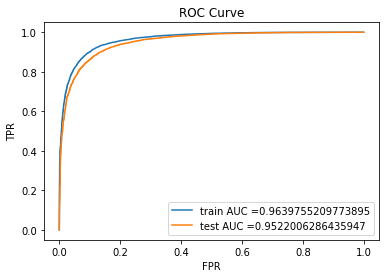

Train confusion matrix
[[ 4173  2175]
 [  551 32501]]
Test confusion matrix
[[ 2904  1777]
 [  511 23774]]
Sparsity on the weight vector
915


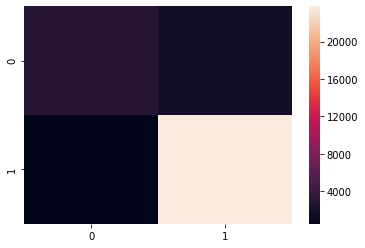

In [351]:
clf = error_plot(tf_idf_train, tf_idf_test, 'l1')
w_tf_idf = clf.coef_
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

[1.99971948e+00 9.99719483e-01 9.92752320e-01 ... 3.92403806e-02
 3.91577198e-02 8.68607605e-04]


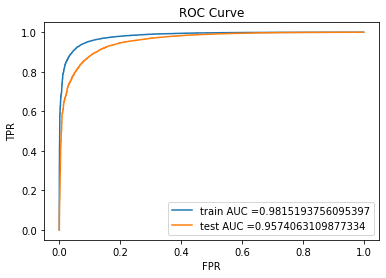

Train confusion matrix
[[ 4073  2275]
 [  236 32816]]
Test confusion matrix
[[ 2539  2142]
 [  296 23989]]
Sparsity on the weight vector
23368


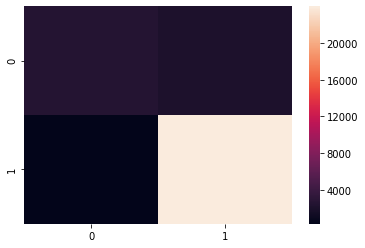

In [352]:
clf = error_plot(tf_idf_train, tf_idf_test, 'l2')
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [353]:
print([tf_idf_vect.get_feature_names()[i] for i in np.argsort(w_tf_idf)[0][-10:]])

['definitely', 'loves', 'good', 'amazing', 'excellent', 'perfect', 'best', 'delicious', 'not disappointed', 'great']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [354]:
print([tf_idf_vect.get_feature_names()[i] for i in np.argsort(w_tf_idf)[0][0:10]])

['two stars', 'disappointed', 'worst', 'disappointment', 'not worth', 'disappointing', 'terrible', 'awful', 'not recommend', 'not good']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

[2.00000000e+00 1.00000000e+00 9.99991655e-01 ... 5.34252500e-03
 1.20537815e-03 6.71740361e-04]


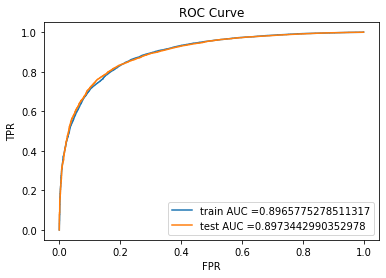

Train confusion matrix
[[ 2873  3475]
 [ 1133 31919]]
Test confusion matrix
[[ 2097  2584]
 [  827 23458]]
Sparsity on the weight vector
50


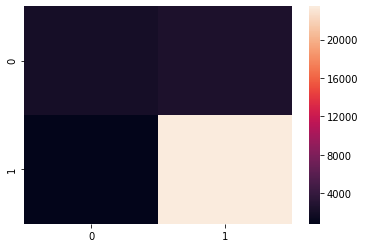

In [355]:
clf = error_plot(avgw2v_train, avgw2v_test, 'l1')
w_avg_w2v = clf.coef_
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

[2.00000000e+00 1.00000000e+00 9.99991861e-01 ... 5.18421044e-03
 1.19165108e-03 7.03705282e-04]


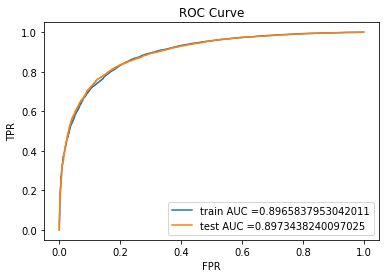

Train confusion matrix
[[ 2876  3472]
 [ 1129 31923]]
Test confusion matrix
[[ 2100  2581]
 [  825 23460]]
Sparsity on the weight vector
50


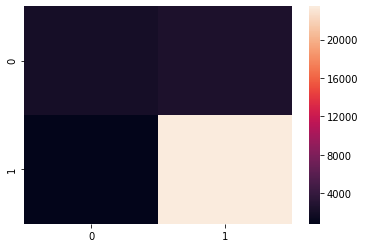

In [356]:
clf = error_plot(avgw2v_train, avgw2v_test, 'l2')
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

[2.         1.         0.9999943  ... 0.01683506 0.00430161 0.00287372]


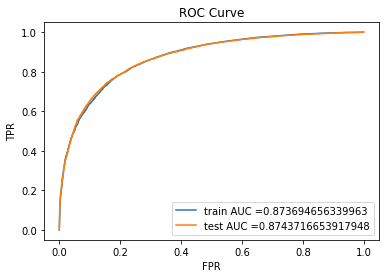

Train confusion matrix
[[ 2387  3961]
 [ 1024 32028]]
Test confusion matrix
[[ 1770  2911]
 [  804 23481]]
Sparsity on the weight vector
49


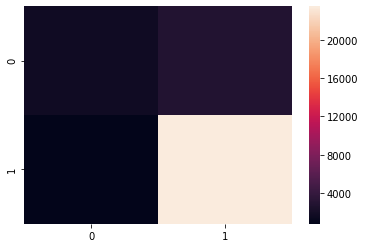

In [357]:
clf = error_plot(tfidfW2V_train, tfidfW2V_test, 'l1')
w_avg_w2v = clf.coef_
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

[2.         1.         0.99999428 ... 0.01677693 0.00429435 0.00285834]


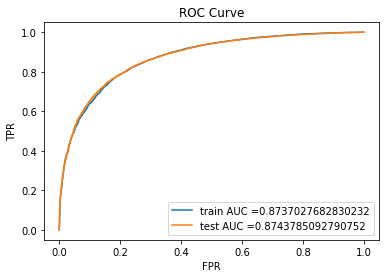

Train confusion matrix
[[ 2392  3956]
 [ 1027 32025]]
Test confusion matrix
[[ 1772  2909]
 [  809 23476]]
Sparsity on the weight vector
50


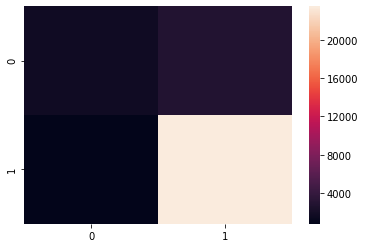

In [358]:
clf = error_plot(tfidfW2V_train, tfidfW2V_test, 'l2')
print('='*100)
print("Sparsity on the weight vector")
print(np.count_nonzero(clf.coef_))

In [359]:
# Please compare all your models using Prettytable library